In [177]:
# neural net zero to hero lecture 6 - completing makemore - Wavenet
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [178]:
# Read in the text file
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [179]:
# Build vocabulary of characters and mappings to integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [180]:
random.seed(42)
random.shuffle(words)

In [181]:
# build the dataset
block_size = 8 # input context length parameter

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182473, 8]) torch.Size([182473])
torch.Size([22827, 8]) torch.Size([22827])
torch.Size([22846, 8]) torch.Size([22846])


In [182]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backpropagation)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1) 
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:
    
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view (B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [183]:
torch.manual_seed(42)

In [184]:
n_embd = 24 # dimensionality of character embedding vectors
n_hidden = 128 # of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
])

with torch.no_grad():
    # last layer: make less confident
    model.layers[-1].weight *= 0.1
            
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
    p.requires_grad = True


76579


In [185]:
# same optimisation as previously
max_steps = 250000
batch_size = 16
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X, Y
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for layer in model.layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 125000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 250000: 3.2875
  10000/ 250000: 2.6081
  20000/ 250000: 1.7738
  30000/ 250000: 1.8352
  40000/ 250000: 1.8585
  50000/ 250000: 2.1378
  60000/ 250000: 1.9305
  70000/ 250000: 2.1591
  80000/ 250000: 1.7942
  90000/ 250000: 2.6422
 100000/ 250000: 2.2336
 110000/ 250000: 2.5124
 120000/ 250000: 1.9198
 130000/ 250000: 1.7834
 140000/ 250000: 1.9873
 150000/ 250000: 1.8215
 160000/ 250000: 1.8488
 170000/ 250000: 1.7016
 180000/ 250000: 2.3793
 190000/ 250000: 2.4870
 200000/ 250000: 1.8130
 210000/ 250000: 1.7805
 220000/ 250000: 2.2231
 230000/ 250000: 1.7226
 240000/ 250000: 2.2199


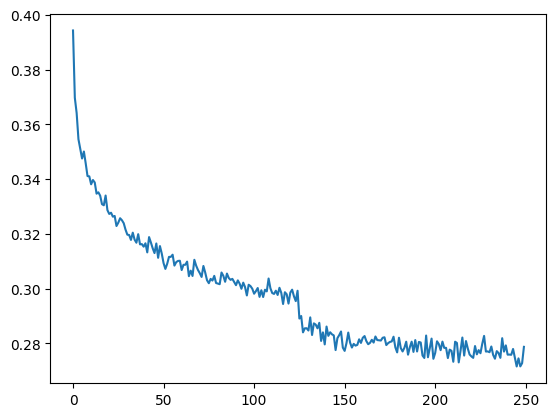

In [186]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [187]:
# put layers into eval mode
for layer in model.layers:
    layer.training = False

In [188]:
# Evaluate the loss
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

# put layers into eval mode
for layer in model.layers:
    layer.training = False
split_loss('train')
split_loss('val')

train 1.87159264087677
val 1.9979819059371948


In [189]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context])) # (1,block_size,n_embd)
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

marley.
lamillia.
nathali.
edrey.
prael.
ismauna.
emiyah.
leael.
hazadee.
keyana.
deejah.
jamayah.
kaysi.
shammari.
emaleus.
nixen.
nathay.
leno.
dacklyn.
yasumy.
